## __GP2 Taller de Bioinformatica Mexico - DEMO 4 - Ejemplos practicos__

```GP2 ❤️ Open Science 😍```

* __Modulo:__ Ejemplos practicos
* __Estimacion de recursos computacionales y duracion del analisis:__
    * __Configuracion de la maquina virtual:__ Por defecto; 1 CPU, 3.75 GB memoria, 50 GB espacio de disco
    * __Duracion estimada:__ 1h.
* __Fecha de ultima actualizacion:__ 28-ENERO-2023

### Descripcion

Utilizando "individual level data" o datos individuales de pacientes y controles veremos los siguientes ejemplos:

__0. Getting Started__

__1. Calcula componentes principales (PCs) para los datos de genotipado de la población EAS__

__2. Crea un “Scree plot”__

__3. Estima que muestras estan emparentadas entre si y si hay muestras duplicadas en los datos de la población SAS__

__4. Estima la frecuencia de GBA - N370S en los datos de la población AJ__

__5. Estima el numero de homozigotos para el alelo de riesgo y heterozigotos para la mutacion LRRK2 G2019S en los datos de la población AJ__

__6. Calcula posibles regiones en homocigosis en chr1 en los datos de la población EUR__

__7. Extrae la region de SNCA y compara los haplotipos en los datos de las poblaciónes AMR y EUR__


## Getting Started

### Cargar librerias de Python

In [1]:
# Use the os package to interact with the environment
import os
import sys

# Bring in Pandas for Dataframe functionality
import pandas as pd
from functools import reduce

# Bring some visualization functionality 
import seaborn as sns

# numpy for basics
import numpy as np

# Use StringIO for working with file contents
from io import StringIO

# Enable IPython to display matplotlib graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Enable interaction with the FireCloud API
from firecloud import api as fapi

# Import the iPython HTML rendering for displaying links to Google Cloud Console
from IPython.core.display import display, HTML

# Import urllib modules for building URLs to Google Cloud Console
import urllib.parse

# BigQuery for querying data
from google.cloud import bigquery

/tmp/ipykernel_1511/3943855956.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Definir funciones de Python para interactuar con GCP/Terra

In [2]:
# Utility routine for printing a shell command before executing it
def shell_do(command):
    print(f'Executing: {command}', file=sys.stderr)
    !$command
    
def shell_return(command):
    print(f'Executing: {command}', file=sys.stderr)
    output = !$command
    return '\n'.join(output)

# Utility routine for printing a query before executing it
def bq_query(query):
    print(f'Executing: {query}', file=sys.stderr)
    return pd.read_gbq(query, project_id=BILLING_PROJECT_ID, dialect='standard')

# Utility routine for display a message and a link
def display_html_link(description, link_text, url):
    html = f'''
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    '''

    display(HTML(html))

# Utility routines for reading files from Google Cloud Storage
def gcs_read_file(path):
    """Return the contents of a file in GCS"""
    contents = !gsutil -u {BILLING_PROJECT_ID} cat {path}
    return '\n'.join(contents)
    
def gcs_read_csv(path, sep=None):
    """Return a DataFrame from the contents of a delimited file in GCS"""
    return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

# Utility routine for displaying a message and link to Cloud Console
def link_to_cloud_console_gcs(description, link_text, gcs_path):
    url = '{}?{}'.format(
        os.path.join('https://console.cloud.google.com/storage/browser',
                     gcs_path.replace("gs://","")),
        urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

    display_html_link(description, link_text, url)

### Inicializar las variables del entorno de trabajo

In [3]:
# Set up billing project and data path variables
BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE_NAME = os.environ['WORKSPACE_NAME']
WORKSPACE_BUCKET = os.environ['WORKSPACE_BUCKET']

WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})

## Print the information to check we are in the proper release and billing 
## This will be different for you, the user, depending on the billing project your workspace is on
print('Billing and Workspace')
print(f'Workspace Name: {WORKSPACE_NAME}')
print(f'Billing Project: {BILLING_PROJECT_ID}')
print(f'Workspace Bucket, where you can upload and download data: {WORKSPACE_BUCKET}')
print('')


## GP2 v3.0
## Explicitly define release v3.0 path 
GP2_RELEASE_PATH = 'gs://gp2tier2/release3_31102022'
GP2_CLINICAL_RELEASE_PATH = f'{GP2_RELEASE_PATH}/clinical_data'
GP2_RAW_GENO_PATH = f'{GP2_RELEASE_PATH}/raw_genotypes'
GP2_IMPUTED_GENO_PATH = f'{GP2_RELEASE_PATH}/imputed_genotypes'
print('GP2 v3.0')
print(f'Path to GP2 v3.0 Clinical Data: {GP2_CLINICAL_RELEASE_PATH}')
print(f'Path to GP2 v3.0 Raw Genotype Data: {GP2_RAW_GENO_PATH}')
print(f'Path to GP2 v3.0 Imputed Genotype Data: {GP2_IMPUTED_GENO_PATH}')


## AMP-PD v3.0
## Explicitly define release v3.0 path 
AMP_RELEASE_PATH = 'gs://amp-pd-data/releases/2022_v3release_1115'
AMP_CLINICAL_RELEASE_PATH = f'{AMP_RELEASE_PATH}/clinical'

AMP_WGS_RELEASE_PATH = 'gs://amp-pd-genomics/releases/2022_v3release_1115/wgs-WB-DWGS'
AMP_WGS_RELEASE_PLINK_PATH = os.path.join(AMP_WGS_RELEASE_PATH, 'plink')

print('AMP-PD v3.0')
print(f'Path to AMP-PD v3.0 Clinical Data: {AMP_CLINICAL_RELEASE_PATH}')
print(f'Path to AMP-PD v3.0 WGS Data: {AMP_WGS_RELEASE_PLINK_PATH}')
print('')

Billing and Workspace
Workspace Name: GRUPO_4_MEXICO_WORKSHOP
Billing Project: terra-61e6143b
Workspace Bucket, where you can upload and download data: gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24

GP2 v3.0
Path to GP2 v3.0 Clinical Data: gs://gp2tier2/release3_31102022/clinical_data
Path to GP2 v3.0 Raw Genotype Data: gs://gp2tier2/release3_31102022/raw_genotypes
Path to GP2 v3.0 Imputed Genotype Data: gs://gp2tier2/release3_31102022/imputed_genotypes
AMP-PD v3.0
Path to AMP-PD v3.0 Clinical Data: gs://amp-pd-data/releases/2022_v3release_1115/clinical
Path to AMP-PD v3.0 WGS Data: gs://amp-pd-genomics/releases/2022_v3release_1115/wgs-WB-DWGS/plink



### Bucket datos GP2 (version 3)

Los ficheros raw estan almacenados en los buckets de <a href="https://cloud.google.com/storage/">Google Cloud Storage</a>:

#### __Tier 2__

- <a href="https://console.cloud.google.com/storage/browser/gp2tier2/release3_31102022?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false">gs://gp2tier2/release3_31102022/</a>: Tier 2 Bucket

- <a href="https://console.cloud.google.com/storage/browser/gp2tier2/release3_31102022/summary_statistics?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false">gs://gp2tier2/release3_31102022/summary_statistics/</a>: Summary Statistics

- <a href="https://console.cloud.google.com/storage/browser/gp2tier2/release3_31102022/raw_genotypes?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false">gs://gp2tier2/release3_31102022/raw_genotypes/</a>: Genotipos raw (ficheros divididos por ascendencia)

- <a href="https://console.cloud.google.com/storage/browser/gp2tier2/release3_31102022/imputed_genotypes?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false">gs://gp2tier2/release3_31102022/imputed_genotypes/</a>: Genotipos imputados (ficheros divididos por ascendencia)

- <a href="https://console.cloud.google.com/storage/browser/gp2tier2/release3_31102022/cnvs?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false">gs://gp2tier2/release3_31102022/cnvs/</a>: Estimacion probabilistica de variaciones en el numero de copias por gen

- <a href="https://console.cloud.google.com/storage/browser/gp2tier2/release3_31102022/clinical_data?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false">gs://gp2tier2/release3_31102022/clinical_data/</a>: Datos clinicos y diccionario

- <a href="https://console.cloud.google.com/storage/browser/gp2tier2/release3_31102022/meta_data?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false">gs://gp2tier2/release3_31102022/meta_data/</a>: Metadatos (fichero hdf5 con control de calidad, ascendencia, componentes principales, etc)

In [4]:
print("Copy over files from bucket to VM workspace")
print("WARNING! This VM, when deleted, deletes all data copied over to it")
print("If you want to store results or files long-term, copy them to your bucket")

Copy over files from bucket to VM workspace
WARNING! This VM, when deleted, deletes all data copied over to it
If you want to store results or files long-term, copy them to your bucket


### Acceder a los datos GP2

In [5]:
## GP2 v3.0
## Explicitly define release v3.0 path 
GP2_RELEASE_PATH = 'gs://gp2tier2/release3_31102022'
GP2_CLINICAL_RELEASE_PATH = f'{GP2_RELEASE_PATH}/clinical_data'
GP2_META_RELEASE_PATH = f'{GP2_RELEASE_PATH}/meta_data'
GP2_SUMSTAT_RELEASE_PATH = f'{GP2_RELEASE_PATH}/summary_statistics'

GP2_RAW_GENO_PATH = f'{GP2_RELEASE_PATH}/raw_genotypes'
GP2_IMPUTED_GENO_PATH = f'{GP2_RELEASE_PATH}/imputed_genotypes'
print('GP2 v3.0')
print(f'Path to GP2 v3.0 Clinical Data: {GP2_CLINICAL_RELEASE_PATH}')
print(f'Path to GP2 v3.0 Raw Genotype Data: {GP2_RAW_GENO_PATH}')
print(f'Path to GP2 v3.0 Imputed Genotype Data: {GP2_IMPUTED_GENO_PATH}')

GP2 v3.0
Path to GP2 v3.0 Clinical Data: gs://gp2tier2/release3_31102022/clinical_data
Path to GP2 v3.0 Raw Genotype Data: gs://gp2tier2/release3_31102022/raw_genotypes
Path to GP2 v3.0 Imputed Genotype Data: gs://gp2tier2/release3_31102022/imputed_genotypes


In [6]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} ls {GP2_RELEASE_PATH}')

Executing: gsutil -u terra-61e6143b ls gs://gp2tier2/release3_31102022


gs://gp2tier2/release3_31102022/
gs://gp2tier2/release3_31102022/README_release3_31102022.txt
gs://gp2tier2/release3_31102022/clinical_data/
gs://gp2tier2/release3_31102022/cnvs/
gs://gp2tier2/release3_31102022/imputed_genotypes/
gs://gp2tier2/release3_31102022/meta_data/
gs://gp2tier2/release3_31102022/raw_genotypes/
gs://gp2tier2/release3_31102022/summary_statistics/
gs://gp2tier2/release3_31102022/utils/
gs://gp2tier2/release3_31102022/wgs/


### Instalar paquetes

In [7]:
%%bash

mkdir -p ~/tools
cd ~/tools

if test -e /home/jupyter/tools/plink; then
echo "Plink1.9 is already installed in /home/jupyter/tools/"

else
echo -e "Downloading plink \n    -------"
wget -N http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20190304.zip 
unzip -o plink_linux_x86_64_20190304.zip
echo -e "\n plink downloaded and unzipped in /home/jupyter/tools \n "

fi


if test -e /home/jupyter/tools/plink2; then
echo "Plink2 is already installed in /home/jupyter/tools/"

else
echo -e "Downloading plink2 \n    -------"
wget -N https://s3.amazonaws.com/plink2-assets/alpha3/plink2_linux_avx2_20220603.zip
unzip -o plink2_linux_avx2_20220603.zip
echo -e "\n plink2 downloaded and unzipped in /home/jupyter/tools \n "

fi

    -------


--2023-12-27 04:52:28--  http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20190304.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.110.77, 52.217.123.40, 52.217.104.174, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.110.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8708135 (8.3M) [application/zip]
Saving to: ‘plink_linux_x86_64_20190304.zip’

     0K .......... .......... .......... .......... ..........  0%  993K 9s
    50K .......... .......... .......... .......... ..........  1% 1.88M 6s
   100K .......... .......... .......... .......... ..........  1% 97.1M 4s
   150K .......... .......... .......... .......... ..........  2% 6.75M 3s
   200K .......... .......... .......... .......... ..........  2% 2.61M 3s
   250K .......... .......... .......... .......... ..........  3%  155M 3s
   300K .......... .......... .......... .......... ..........  4%  186M 2s
   350K .......... .......... .......... .......... ......

Archive:  plink_linux_x86_64_20190304.zip
  inflating: plink                   
  inflating: LICENSE                 
  inflating: toy.ped                 
  inflating: toy.map                 
  inflating: prettify                

 plink downloaded and unzipped in /home/jupyter/tools 
 
    -------


--2023-12-27 04:52:29--  https://s3.amazonaws.com/plink2-assets/alpha3/plink2_linux_avx2_20220603.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.110.77, 52.217.123.40, 52.217.104.174, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.110.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9111524 (8.7M) [application/zip]
Saving to: ‘plink2_linux_avx2_20220603.zip’

     0K .......... .......... .......... .......... ..........  0% 2.08M 4s
    50K .......... .......... .......... .......... ..........  1% 1.87M 4s
   100K .......... .......... .......... .......... ..........  1% 1.87M 4s
   150K .......... .......... .......... .......... ..........  2%  169M 3s
   200K .......... .......... .......... .......... ..........  2%  166M 3s
   250K .......... .......... .......... .......... ..........  3% 1.90M 3s
   300K .......... .......... .......... .......... ..........  3%  168M 2s
   350K .......... .......... .......... ..........

Archive:  plink2_linux_avx2_20220603.zip
  inflating: plink2                  

 plink2 downloaded and unzipped in /home/jupyter/tools 
 


In [8]:
%%bash
ls /home/jupyter/tools/

LICENSE
plink
plink2
plink2_linux_avx2_20220603.zip
plink_linux_x86_64_20190304.zip
prettify
toy.map
toy.ped


## Calcula componentes principales (PCs) para los datos de genotipado de la población EAS

In [9]:
# Crea una carpeta en tu "workspace" donde vamos a ejecutar los analisis
print("Making a working directory")
WORK_DIR = f'/home/jupyter/EJERCICIO_1'
shell_do(f'mkdir -p {WORK_DIR}')

Making a working directory


Executing: mkdir -p /home/jupyter/EJERCICIO_1


In [10]:
## Importa desde el bucket GP2-Tier 2 los genotipos "raw" de la poblacion EAS
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_RELEASE_PATH}/raw_genotypes/EAS {WORK_DIR}')

Executing: gsutil -u terra-61e6143b -m cp -r gs://gp2tier2/release3_31102022/raw_genotypes/EAS /home/jupyter/EJERCICIO_1


Copying gs://gp2tier2/release3_31102022/raw_genotypes/EAS/GP2_round3_EAS_maf_hwe_release3.pgen...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/EAS/GP2_round3_EAS_maf_hwe_release3.psam...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/EAS/GP2_round3_EAS_maf_hwe_release3.log...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/EAS/GP2_round3_EAS_maf_hwe_release3.pvar...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/EAS/GP2_round3_EAS_maf_hwe_release3.samples...
- [5/5 files][ 39.7 MiB/ 39.7 MiB] 100% Done                                    
Operation completed over 5 objects/39.7 MiB.                                     


### Visualiza los archivos plink *pvar, *psam y *pgen (en bash)

In [11]:
! ls {WORK_DIR}/EAS/ # Explora los archivos dentro de la carpeta 

GP2_round3_EAS_maf_hwe_release3.log   GP2_round3_EAS_maf_hwe_release3.pvar
GP2_round3_EAS_maf_hwe_release3.pgen  GP2_round3_EAS_maf_hwe_release3.samples
GP2_round3_EAS_maf_hwe_release3.psam


In [12]:
# Formato Plink2:
# *psam contiene FID, IID, SEX, PHENO1 columns
# *pvar contiene CHROM, POS, ID, REF, ALT columns
# *pgen contiene una matrix que no se puede visualizar

! head {WORK_DIR}/EAS/GP2_round3_EAS_maf_hwe_release3.psam
! head {WORK_DIR}/EAS/GP2_round3_EAS_maf_hwe_release3.pvar
! head {WORK_DIR}/EAS/GP2_round3_EAS_maf_hwe_release3.pgen


#FID	IID	SEX	PHENO1
0	APGS_000051_s1	1	2
0	APGS_000113_s1	1	2
0	APGS_000135_s1	1	2
0	APGS_000186_s1	1	2
0	APGS_000201_s1	1	2
0	APGS_000204_s1	2	2
0	APGS_000263_s1	1	2
0	APGS_000314_s1	2	2
0	APGS_000415_s1	2	2
#CHROM	POS	ID	REF	ALT
0	0	10:47074788-A-G	G	A
0	0	10:47084956-C-T	A	G
0	0	15:23279911-C-T	A	G
0	0	1:144677777-T-C	G	A
0	0	1:144863320-TC	A	G
0	0	1:144863401-TC	A	G
0	0	1:144879339-CT	G	A
0	0	1:144931251-CT	G	A
0	0	1:145014096-GA	G	A
##	##		########	#			     ��x     ���     ���     w��     Z(�     0�     �N�     �    DDA@@@DDD "AA!@DD DBA A!D@@DDB!B ADBA!AADA"DAAD!A@A ""@$@@"@   @!A@D@@@  @D@@@ D@A A  @D@AD D  "B!B@ $ DAA DDAA@@  " @  @ @ A @"DD @DDAD AD@ D ADAD"!@$@@DA A@ D@AB@ D@D D DA!A@   @!@! @ DAADAAD! DDDA@ A@!BA  @ DAA"@A!"DAAA

In [13]:
# Visualizar el archivo *log 

! head {WORK_DIR}/EAS/GP2_round3_EAS_maf_hwe_release3.log

PLINK v2.00a1LM 64-bit Intel (11 Feb 2018)
Options in effect:
  --bfile /data/CARD/PD/GP2/genotypes/GP2/round3/clean/GP2_round3_NEW_MERGE_EAS_maf_hwe
  --keep /data/CARD/PD/GP2/genotypes/GP2/round3/clean/GP2_round3_EAS_maf_hwe_release3.samples
  --make-pgen
  --out /data/CARD/PD/GP2/genotypes/GP2/round3/clean/GP2_round3_EAS_maf_hwe_release3

Hostname: cn0904
Working directory: /gpfs/gsfs6/users/levineks/GP2
Start time: Fri Oct 28 12:02:52 2022


### Visualiza los archivos *pvar, *psam y *pgen (en python)

In [14]:
psam = pd.read_csv(f'{WORK_DIR}/EAS/GP2_round3_EAS_maf_hwe_release3.psam', sep = '\t')
psam.head()

,#FID,IID,SEX,PHENO1
0,0,APGS_000051_s1,1,2
1,0,APGS_000113_s1,1,2
2,0,APGS_000135_s1,1,2
3,0,APGS_000186_s1,1,2
4,0,APGS_000201_s1,1,2


In [15]:
pvar= pd.read_csv(f'{WORK_DIR}/EAS/GP2_round3_EAS_maf_hwe_release3.pvar', sep = '\t')
pvar.head()

/tmp/ipykernel_1511/2695683932.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  pvar= pd.read_csv(f'{WORK_DIR}/EAS/GP2_round3_EAS_maf_hwe_release3.pvar', sep = '\t')


,#CHROM,POS,ID,REF,ALT
0,0,0,10:47074788-A-G,G,A
1,0,0,10:47084956-C-T,A,G
2,0,0,15:23279911-C-T,A,G
3,0,0,1:144677777-T-C,G,A
4,0,0,1:144863320-TC,A,G


### Calcula componentes principales

In [16]:
%%bash
WORK_DIR=/home/jupyter/EJERCICIO_1/
cd $WORK_DIR

# Utiliza variantes con calidad optima. Descarta variantes raras
/home/jupyter/tools/plink2 --pfile EAS/GP2_round3_EAS_maf_hwe_release3 --maf 0.01 --geno 0.05 --hwe 1E-6 --make-bed --out EJEMPLO_1

# Filtra variantes independientes (pruning)
/home/jupyter/tools/plink2 --bfile EJEMPLO_1 --indep-pairwise 50 5 0.5 --out prune

# Extrae variantes filtradas
/home/jupyter/tools/plink2 --bfile EJEMPLO_1 --extract prune.prune.in --make-bed --out prune

# Calcula PCs
/home/jupyter/tools/plink2 --bfile prune --pca 10 --out EJEMPLO_1.PCA

PLINK v2.00a3.3LM AVX2 Intel (3 Jun 2022)      www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to EJEMPLO_1.log.
Options in effect:
  --geno 0.05
  --hwe 1E-6
  --maf 0.01
  --make-bed
  --out EJEMPLO_1
  --pfile EAS/GP2_round3_EAS_maf_hwe_release3

Start time: Wed Dec 27 04:52:43 2023
3676 MiB RAM detected; reserving 1838 MiB for main workspace.
Using 1 compute thread.
137 samples (52 females, 85 males; 137 founders) loaded from
EAS/GP2_round3_EAS_maf_hwe_release3.psam.
840075 variants loaded from EAS/GP2_round3_EAS_maf_hwe_release3.pvar.
1 binary phenotype loaded (104 cases, 33 controls).
Calculating allele frequencies... 1523313946546270788593done.
--geno: 27492 variants removed due to missing genotype data.
Computing chrX Hardy-Weinberg p-values... 1010111112121313141415151616171718181919202021212222232324242525262627272828292930303131323233333434353536363737383839394040414142424343444445454646474748484949505051

--geno, and/or applying different p-value thresholds to distinct subsets of
your data.


--hwe: 6 variants removed due to Hardy-Weinberg exact test (founders only).
62598 variants removed due to allele frequency threshold(s)
(--maf/--max-maf/--mac/--max-mac).
749979 variants remaining after main filters.
Writing EJEMPLO_1.fam ... done.
Writing EJEMPLO_1.bim ... done.
Writing EJEMPLO_1.bed ... 1523313946546270788693done.
End time: Wed Dec 27 04:52:44 2023
PLINK v2.00a3.3LM AVX2 Intel (3 Jun 2022)      www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to prune.log.
Options in effect:
  --bfile EJEMPLO_1
  --indep-pairwise 50 5 0.5
  --out prune

Start time: Wed Dec 27 04:52:44 2023
3676 MiB RAM detected; reserving 1838 MiB for main workspace.
Using 1 compute thread.
137 samples (52 females, 85 males; 137 founders) loaded from EJEMPLO_1.fam.
749979 variants loaded from EJEMPLO_1.bim.
1 binary phenotype loaded (104 cases, 33 controls).
Calculating allele frequencies... 17263443526169788796done.
--indep-pairwi

In [17]:
%%bash
WORK_DIR=/home/jupyter/EJERCICIO_1/
cd $WORK_DIR

head EJEMPLO_1.PCA.eigenvec

#FID	IID	PC1	PC2	PC3	PC4	PC5	PC6	PC7	PC8	PC9	PC10
0	APGS_000051_s1	0.0380752	0.0676968	0.00329508	-0.069545	-0.0434179	-0.0333652	-0.0413233	0.00685397	-0.0261765	-0.0240971
0	APGS_000113_s1	-0.00809064	0.0659355	-0.0264762	0.0211067	-0.0189945	0.0587418	0.0383859	0.00923688	0.0838931	-0.0492883
0	APGS_000135_s1	-0.0169093	0.0661386	-0.030057	0.0181156	-0.031205	0.0389084	0.0368215	0.0252988	0.0270844	-0.00303184
0	APGS_000186_s1	0.0203702	0.054612	-0.00012354	-0.0253828	-0.0214954	-0.0364197	0.00450415	-0.0593161	0.0367202	-0.107248
0	APGS_000201_s1	0.0172614	0.0635851	-0.00397269	-0.0574377	0.000567505	-0.0429637	0.00211394	0.00491069	-0.0863221	-0.0802582
0	APGS_000204_s1	0.0357435	0.0524748	0.000828454	-0.119189	0.00291202	-0.0672826	-0.0552363	-0.001515	-0.0616961	-0.0119103
0	APGS_000263_s1	0.132403	-0.0825484	-0.0655674	0.00839186	0.0470194	0.0022924	-0.021393	0.109509	-0.0596602	-0.0780649
0	APGS_000314_s1	-0.0608043	0.0474488	-0.0209897	0.113576	0.0120864	0.0535251	-0.00886369

In [18]:
componentes_principales_eigenvec = pd.read_csv(f'{WORK_DIR}/EJEMPLO_1.PCA.eigenvec', delim_whitespace=True)
componentes_principales_eigenvec.head()

,#FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0,APGS_000051_s1,0.038075,0.067697,0.003295,-0.069545,-0.043418,-0.033365,-0.041323,0.006854,-0.026176,-0.024097
1,0,APGS_000113_s1,-0.008091,0.065935,-0.026476,0.021107,-0.018995,0.058742,0.038386,0.009237,0.083893,-0.049288
2,0,APGS_000135_s1,-0.016909,0.066139,-0.030057,0.018116,-0.031205,0.038908,0.036822,0.025299,0.027084,-0.003032
3,0,APGS_000186_s1,0.020370,0.054612,-0.000124,-0.025383,-0.021495,-0.036420,0.004504,-0.059316,0.036720,-0.107248
4,0,APGS_000201_s1,0.017261,0.063585,-0.003973,-0.057438,0.000568,-0.042964,0.002114,0.004911,-0.086322,-0.080258


In [19]:
componentes_principales_eigenval = pd.read_csv(f'{WORK_DIR}/EJEMPLO_1.PCA.eigenval', sep = '\t', header = None)
componentes_principales_eigenval.head()

,0
0,1.92447
1,1.51498
2,1.23161
3,1.17151
4,1.12876


In [20]:
! ls /home/jupyter/EJERCICIO_1

EAS	       EJEMPLO_1.log	       prune.bed  prune.prune.in
EJEMPLO_1.bed  EJEMPLO_1.PCA.eigenval  prune.bim  prune.prune.out
EJEMPLO_1.bim  EJEMPLO_1.PCA.eigenvec  prune.fam
EJEMPLO_1.fam  EJEMPLO_1.PCA.log       prune.log


## Crea un “scree plot” (grafico de sedimentacion)

In [21]:
# Crea una carpeta en tu "workspace" donde vamos a ejecutar los analisis
print("Making a working directory")
WORK_DIR = f'/home/jupyter/EJERCICIO_2'
shell_do(f'mkdir -p {WORK_DIR}')

Making a working directory


Executing: mkdir -p /home/jupyter/EJERCICIO_2


Read in pca.eigenval files from PLINK


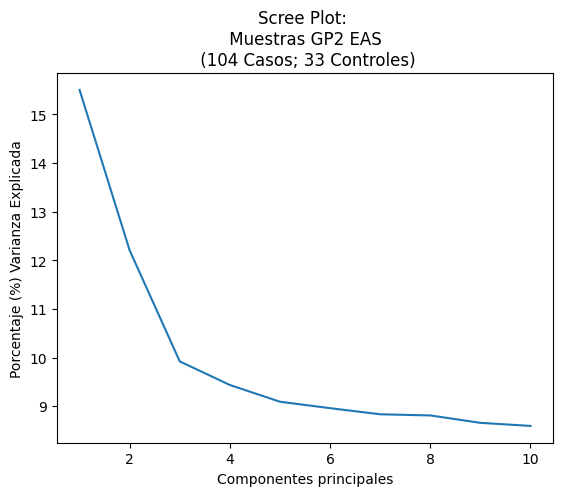

In [22]:
import matplotlib.pyplot as plt

# Lee los archivos del analisis de componentes principales - Eigenvalues and Eigenvectors
print("Read in pca.eigenval files from PLINK")
eigenval = pd.read_csv(f'/home/jupyter/EJERCICIO_1/EJEMPLO_1.PCA.eigenval', delimiter="\t", header=None)

# Actualiza el nombre de las columnas
eigenval.columns = ["Eigenvalues"]
eigenval["PC"] = eigenval.index + 1
eigenval["VarianceExplained"] = eigenval["Eigenvalues"] / eigenval["Eigenvalues"].sum() * 100

# Extrae solo los primeros 10PCs
eigenval2 = eigenval.head(10)

# Genera el plot
plt.plot(eigenval2["PC"], eigenval2["VarianceExplained"])
plt.xlabel("Componentes principales")
plt.ylabel("Porcentaje (%) Varianza Explicada")
plt.title("Scree Plot: \n Muestras GP2 EAS \n (104 Casos; 33 Controles)")

# Guarda tu plot en PDF y JPEG
plt.savefig(f'{WORK_DIR}/ScreePlot_GP2_EAS_unrelated.pdf')
plt.savefig(f'{WORK_DIR}/ScreePlot_GP2_EAS_unrelated.jpg')
plt.show()

In [23]:
! ls /home/jupyter/EJERCICIO_2

ScreePlot_GP2_EAS_unrelated.jpg  ScreePlot_GP2_EAS_unrelated.pdf


## Estima que muestras estan emparentadas entre si y si hay muestras duplicadas en los datos de la población SAS

In [24]:
# Crea una carpeta en tu "workspace" donde vamos a ejecutar los analisis
print("Making a working directory")
WORK_DIR = f'/home/jupyter/EJERCICIO_3'
shell_do(f'mkdir -p {WORK_DIR}')

Making a working directory


Executing: mkdir -p /home/jupyter/EJERCICIO_3


In [25]:
## Importa desde el bucket GP2-Tier 2 los genotipos "raw" de la poblacion SAS
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_RELEASE_PATH}/raw_genotypes/SAS {WORK_DIR}')

Executing: gsutil -u terra-61e6143b -m cp -r gs://gp2tier2/release3_31102022/raw_genotypes/SAS /home/jupyter/EJERCICIO_3


Copying gs://gp2tier2/release3_31102022/raw_genotypes/SAS/GP2_round3_SAS_maf_hwe_release3.pgen...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/SAS/GP2_round3_SAS_maf_hwe_release3.psam...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/SAS/GP2_round3_SAS_maf_hwe_release3.pvar...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/SAS/GP2_round3_SAS_maf_hwe_release3.log...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/SAS/GP2_round3_SAS_maf_hwe_release3.samples...
\ [5/5 files][ 35.8 MiB/ 35.8 MiB] 100% Done                                    
Operation completed over 5 objects/35.8 MiB.                                     


In [26]:
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORKSPACE_BUCKET}/gcta /home/jupyter/tools/')

# Pasos:
# Descarga gcta desde https://yanglab.westlake.edu.cn/software/gcta/#Download
# Adjunta el ejecutable en tu workspace (accede a la carpeta "Data" y clica "Upload")
# Copia gcta desde tu workspace a tu working directory

Executing: gsutil -mu terra-61e6143b cp -r gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/gcta /home/jupyter/tools/


Copying gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/gcta...
| [1/1 files][ 43.0 MiB/ 43.0 MiB] 100% Done                                    
Operation completed over 1 objects/43.0 MiB.                                     


In [27]:
%%bash
# Elimina los permisos de acceso
chmod u+x /home/jupyter/tools/gcta

In [28]:
%%bash
WORK_DIR=/home/jupyter/EJERCICIO_3/
cd $WORK_DIR

/home/jupyter/tools/plink2 --pfile SAS/GP2_round3_SAS_maf_hwe_release3 --geno 0.01 --maf 0.05 --indep-pairwise 50 5 0.5 --out pruning
/home/jupyter/tools/plink2 --pfile SAS/GP2_round3_SAS_maf_hwe_release3 --extract pruning.prune.in --make-bed --out pruned_data
/home/jupyter/tools/plink2 --bfile pruned_data --het --out prunedHet

/home/jupyter/tools/gcta --bfile pruned_data --make-grm --out GRM_matrix --autosome --maf 0.05 
/home/jupyter/tools/gcta --grm-cutoff 0.125 --grm GRM_matrix --out GRM_matrix_0125 --make-grm
/home/jupyter/tools/plink2 --pfile SAS/GP2_round3_SAS_maf_hwe_release3 --remove GRM_matrix_0125.grm.id --make-bed --out muestras_emparentadas

head muestras_emparentadas.fam
cut -f 1,2 muestras_emparentadas.fam > lista_muestras_emparentadas.txt
cat lista_muestras_emparentadas.txt

PLINK v2.00a3.3LM AVX2 Intel (3 Jun 2022)      www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to pruning.log.
Options in effect:
  --geno 0.01
  --indep-pairwise 50 5 0.5
  --maf 0.05
  --out pruning
  --pfile SAS/GP2_round3_SAS_maf_hwe_release3

Start time: Wed Dec 27 04:53:04 2023
3676 MiB RAM detected; reserving 1838 MiB for main workspace.
Using 1 compute thread.
59 samples (22 females, 37 males; 59 founders) loaded from
SAS/GP2_round3_SAS_maf_hwe_release3.psam.
972779 variants loaded from SAS/GP2_round3_SAS_maf_hwe_release3.pvar.
1 binary phenotype loaded (42 cases, 17 controls).
Calculating allele frequencies... 13202633404753606774808794done.
--geno: 75520 variants removed due to missing genotype data.
274492 variants removed due to allele frequency threshold(s)
(--maf/--max-maf/--mac/--max-mac).
622767 variants remaining after main filters.
--indep-pairwise: Ignoring 387 chromosome 0 variants.
--indep-pairw

In [29]:
%%bash
WORK_DIR=/home/jupyter/EJERCICIO_3/
cd $WORK_DIR

/home/jupyter/tools/plink2 --pfile SAS/GP2_round3_SAS_maf_hwe_release3 --geno 0.01 --maf 0.05 --indep-pairwise 50 5 0.5 --out pruning
/home/jupyter/tools/plink2 --pfile SAS/GP2_round3_SAS_maf_hwe_release3 --extract pruning.prune.in --make-bed --out pruned_data
/home/jupyter/tools/plink2 --bfile pruned_data --het --out prunedHet

/home/jupyter/tools/gcta --bfile pruned_data --make-grm --out GRM_matrix --autosome --maf 0.05 
/home/jupyter/tools/gcta --grm-cutoff 0.8 --grm GRM_matrix --out GRM_matrix_08 --make-grm
/home/jupyter/tools/plink2 --pfile SAS/GP2_round3_SAS_maf_hwe_release3 --remove GRM_matrix_08.grm.id --make-bed --out muestras_duplicadas

head muestras_duplicadas.fam
cut -f 1,2 muestras_duplicadas.fam > lista_muestras_duplicadas.txt
cat lista_muestras_duplicadas.txt

PLINK v2.00a3.3LM AVX2 Intel (3 Jun 2022)      www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to pruning.log.
Options in effect:
  --geno 0.01
  --indep-pairwise 50 5 0.5
  --maf 0.05
  --out pruning
  --pfile SAS/GP2_round3_SAS_maf_hwe_release3

Start time: Wed Dec 27 04:53:08 2023
3676 MiB RAM detected; reserving 1838 MiB for main workspace.
Using 1 compute thread.
59 samples (22 females, 37 males; 59 founders) loaded from
SAS/GP2_round3_SAS_maf_hwe_release3.psam.
972779 variants loaded from SAS/GP2_round3_SAS_maf_hwe_release3.pvar.
1 binary phenotype loaded (42 cases, 17 controls).
Calculating allele frequencies... 13202633404753606774808794done.
--geno: 75520 variants removed due to missing genotype data.
274492 variants removed due to allele frequency threshold(s)
(--maf/--max-maf/--mac/--max-mac).
622767 variants remaining after main filters.
--indep-pairwise: Ignoring 387 chromosome 0 variants.
--indep-pairw

Error: No samples remaining after main filters.


End time: Wed Dec 27 04:53:11 2023


head: cannot open 'muestras_duplicadas.fam' for reading: No such file or directory
cut: muestras_duplicadas.fam: No such file or directory


In [30]:
! ls /home/jupyter/EJERCICIO_3/

GRM_matrix_0125.grm.bin    GRM_matrix.grm.N.bin		    pruned_data.bim
GRM_matrix_0125.grm.id	   GRM_matrix.log		    pruned_data.fam
GRM_matrix_0125.grm.N.bin  lista_muestras_duplicadas.txt    pruned_data.log
GRM_matrix_0125.log	   lista_muestras_emparentadas.txt  prunedHet.het
GRM_matrix_08.grm.bin	   muestras_duplicadas.log	    prunedHet.log
GRM_matrix_08.grm.id	   muestras_emparentadas.bed	    pruning.log
GRM_matrix_08.grm.N.bin    muestras_emparentadas.bim	    pruning.prune.in
GRM_matrix_08.log	   muestras_emparentadas.fam	    pruning.prune.out
GRM_matrix.grm.bin	   muestras_emparentadas.log	    SAS
GRM_matrix.grm.id	   pruned_data.bed


## Estima la frecuencia de GBA - N370S en los datos de la población AJ

In [31]:
# Crea una carpeta en tu "workspace" donde vamos a ejecutar los analisis
print("Making a working directory")
WORK_DIR = f'/home/jupyter/EJERCICIO_4'
shell_do(f'mkdir -p {WORK_DIR}')

Making a working directory


Executing: mkdir -p /home/jupyter/EJERCICIO_4


In [32]:
## Importa desde el bucket GP2-Tier 2 los genotipos "raw" de la poblacion SAS
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_RELEASE_PATH}/raw_genotypes/AJ {WORK_DIR}')

Executing: gsutil -u terra-61e6143b -m cp -r gs://gp2tier2/release3_31102022/raw_genotypes/AJ /home/jupyter/EJERCICIO_4


Copying gs://gp2tier2/release3_31102022/raw_genotypes/AJ/GP2_round3_AJ_maf_hwe_release3.pvar...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/AJ/GP2_round3_AJ_maf_hwe_release3.psam...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/AJ/GP2_round3_AJ_maf_hwe_release3.log...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/AJ/GP2_round3_AJ_maf_hwe_release3.pgen...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/AJ/GP2_round3_AJ_maf_hwe_release3.samples...
- [5/5 files][192.7 MiB/192.7 MiB] 100% Done                                    
Operation completed over 5 objects/192.7 MiB.                                    


In [33]:
%%bash
WORK_DIR=/home/jupyter/EJERCICIO_4/
cd $WORK_DIR

# Extrae GBA N370S considerando que sus posiciones estan en hg38 (https://www.ncbi.nlm.nih.gov/clinvar/variation/4290/?new_evidence=true)
/home/jupyter/tools/plink2 --pfile AJ/GP2_round3_AJ_maf_hwe_release3 --chr 1 --from-bp 155235843 --to-bp 155235843 --make-bed --out GBA_N370S

#Date cuenta que defines el tramo del chr a utilizar donde se encuentra GBA

PLINK v2.00a3.3LM AVX2 Intel (3 Jun 2022)      www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to GBA_N370S.log.
Options in effect:
  --chr 1
  --from-bp 155235843
  --make-bed
  --out GBA_N370S
  --pfile AJ/GP2_round3_AJ_maf_hwe_release3
  --to-bp 155235843

Start time: Wed Dec 27 04:53:22 2023
3676 MiB RAM detected; reserving 1838 MiB for main workspace.
Using 1 compute thread.
1285 samples (477 females, 808 males; 1285 founders) loaded from
AJ/GP2_round3_AJ_maf_hwe_release3.psam.
69602 out of 940435 variants loaded from
AJ/GP2_round3_AJ_maf_hwe_release3.pvar.
1 binary phenotype loaded (600 cases, 323 controls).
3 variants remaining after main filters.
Writing GBA_N370S.fam ... done.
Writing GBA_N370S.bim ... done.
Writing GBA_N370S.bed ... done.
End time: Wed Dec 27 04:53:22 2023


In [34]:
GBA_N370S = pd.read_csv(f'{WORK_DIR}/GBA_N370S.bim', sep = '\t', header = None)
GBA_N370S.head()

,0,1,2,3,4,5
0,1,chr1:155235843:T:C,0,155235843,G,A
1,1,exm106217,0,155235843,G,A
2,1,ilmnseq_rs76763715.1_F2BT,0,155235843,G,A


In [35]:
%%bash
WORK_DIR=/home/jupyter/EJERCICIO_4/
cd $WORK_DIR

# Extrae GBA N370S considerando que sus posiciones estan en hg38 (https://www.ncbi.nlm.nih.gov/clinvar/variation/4290/?new_evidence=true)
/home/jupyter/tools/plink2 --bfile GBA_N370S --freq --out GBA_N370S_frecuencia


PLINK v2.00a3.3LM AVX2 Intel (3 Jun 2022)      www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to GBA_N370S_frecuencia.log.
Options in effect:
  --bfile GBA_N370S
  --freq
  --out GBA_N370S_frecuencia

Start time: Wed Dec 27 04:53:22 2023
3676 MiB RAM detected; reserving 1838 MiB for main workspace.
Using 1 compute thread.
1285 samples (477 females, 808 males; 1285 founders) loaded from GBA_N370S.fam.
3 variants loaded from GBA_N370S.bim.
1 binary phenotype loaded (600 cases, 323 controls).
Calculating allele frequencies... done.
--freq: Allele frequencies (founders only) written to
GBA_N370S_frecuencia.afreq .
End time: Wed Dec 27 04:53:22 2023


In [36]:
GBA_N370S_frecuencia = pd.read_csv(f'{WORK_DIR}/GBA_N370S_frecuencia.afreq', sep = '\t')
GBA_N370S_frecuencia.head()

,#CHROM,ID,REF,ALT,ALT_FREQS,OBS_CT
0,1,chr1:155235843:T:C,A,G,0.103891,2570
1,1,exm106217,A,G,0.080172,1160
2,1,ilmnseq_rs76763715.1_F2BT,A,G,0.105118,2540


In [37]:
%%bash
WORK_DIR=/home/jupyter/EJERCICIO_4/
cd $WORK_DIR

# Extrae GBA N370S considerando que sus posiciones estan en hg38 (https://www.ncbi.nlm.nih.gov/clinvar/variation/4290/?new_evidence=true)
/home/jupyter/tools/plink --bfile GBA_N370S --assoc --out GBA_N370S_frecuencia_casos_controls


PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to GBA_N370S_frecuencia_casos_controls.log.
Options in effect:
  --assoc
  --bfile GBA_N370S
  --out GBA_N370S_frecuencia_casos_controls

3676 MB RAM detected; reserving 1838 MB for main workspace.
3 variants loaded from .bim file.
1285 people (808 males, 477 females) loaded from .fam.
923 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 1285 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.81323.
3 variants and 1285 people pass filters and QC.
Among remaining phenotypes, 600 are cases and 323 are controls.  (362
phenotypes are missing.)
Writing C/C --assoc repor

## Estima el numero de homozigotos para el alelo de riesgo y heterozigotos para la mutacion LRRK2 G2019S en los datos en los datos de la población AJ

In [39]:
# Crea una carpeta en tu "workspace" donde vamos a ejecutar los analisis
print("Making a working directory")
WORK_DIR = f'/home/jupyter/EJERCICIO_5'
shell_do(f'mkdir -p {WORK_DIR}')

Making a working directory


Executing: mkdir -p /home/jupyter/EJERCICIO_5


In [40]:
## Importa desde el bucket GP2-Tier 2 los genotipos "raw" de la poblacion AJ
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_RELEASE_PATH}/raw_genotypes/AJ {WORK_DIR}')

Executing: gsutil -u terra-61e6143b -m cp -r gs://gp2tier2/release3_31102022/raw_genotypes/AJ /home/jupyter/EJERCICIO_5


Copying gs://gp2tier2/release3_31102022/raw_genotypes/AJ/GP2_round3_AJ_maf_hwe_release3.pvar...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/AJ/GP2_round3_AJ_maf_hwe_release3.psam...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/AJ/GP2_round3_AJ_maf_hwe_release3.pgen...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/AJ/GP2_round3_AJ_maf_hwe_release3.log...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/AJ/GP2_round3_AJ_maf_hwe_release3.samples...
/ [5/5 files][192.7 MiB/192.7 MiB] 100% Done                                    
Operation completed over 5 objects/192.7 MiB.                                    


In [41]:
%%bash
WORK_DIR=/home/jupyter/EJERCICIO_5/
cd $WORK_DIR

# Extrae LRRK2 G2019 considerando que sus posiciones estan en hg38 (https://www.ncbi.nlm.nih.gov/clinvar/variation/4290/?new_evidence=true)
/home/jupyter/tools/plink2 --pfile AJ/GP2_round3_AJ_maf_hwe_release3 --chr 12 --from-bp 40340400 --to-bp 40340400  --make-bed --out LRRK2_G2019


PLINK v2.00a3.3LM AVX2 Intel (3 Jun 2022)      www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to LRRK2_G2019.log.
Options in effect:
  --chr 12
  --from-bp 40340400
  --make-bed
  --out LRRK2_G2019
  --pfile AJ/GP2_round3_AJ_maf_hwe_release3
  --to-bp 40340400

Start time: Wed Dec 27 04:54:18 2023
3676 MiB RAM detected; reserving 1838 MiB for main workspace.
Using 1 compute thread.
1285 samples (477 females, 808 males; 1285 founders) loaded from
AJ/GP2_round3_AJ_maf_hwe_release3.psam.
42552 out of 940435 variants loaded from
AJ/GP2_round3_AJ_maf_hwe_release3.pvar.
1 binary phenotype loaded (600 cases, 323 controls).
3 variants remaining after main filters.
Writing LRRK2_G2019.fam ... done.
Writing LRRK2_G2019.bim ... done.
Writing LRRK2_G2019.bed ... done.
End time: Wed Dec 27 04:54:18 2023


In [42]:
%%bash
WORK_DIR=/home/jupyter/EJERCICIO_5/
cd $WORK_DIR

# Extrae LRRK2 G2019 considerando que sus posiciones estan en hg38 (https://www.ncbi.nlm.nih.gov/clinvar/variation/4290/?new_evidence=true)
/home/jupyter/tools/plink2 --bfile LRRK2_G2019 --recode A --out LRRK2_G2019

#Recode A: Genera un archivo .raw 

PLINK v2.00a3.3LM AVX2 Intel (3 Jun 2022)      www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to LRRK2_G2019.log.
Options in effect:
  --bfile LRRK2_G2019
  --export A
  --out LRRK2_G2019

Start time: Wed Dec 27 04:54:18 2023
3676 MiB RAM detected; reserving 1838 MiB for main workspace.
Using 1 compute thread.
1285 samples (477 females, 808 males; 1285 founders) loaded from
LRRK2_G2019.fam.
3 variants loaded from LRRK2_G2019.bim.
1 binary phenotype loaded (600 cases, 323 controls).
--export A pass 1/1: loading... 0writing... 10101111121213131414151516161717181819202021212222232324242525262627272828292930303131323233333434353536363737383839404041414242434344444545464647474848494950505151525253535454555556565757585859606061616262636364646565666667676868696970707171727273737474757576767777787879808081818282838384848585868687878888898990909191929293939494959596969797989899done.
--export A: LRRK2_G2019.raw written.
End 

In [43]:
# Identifica individuos homozygotos para el alelo alternativo
LRRK2 = pd.read_csv(f'{WORK_DIR}/LRRK2_G2019.raw', sep = '\t')
homo = LRRK2[LRRK2['rs34637584_G'] == 2]
homo.head()

,FID,IID,PAT,MAT,SEX,PHENOTYPE,exm994671_G,rs34637584_G,seq_rs34637584_G
2,0,APGS_000486_s1,0,0,1,2,2,2,2
3,0,APGS_000646_s1,0,0,2,2,2,2,2
4,0,APGS_000808_s1,0,0,1,2,2,2,2
5,0,APGS_001017_s1,0,0,1,2,2,2,2
7,0,APGS_001066_s1,0,0,2,2,2,2,2


In [44]:
het_cases = LRRK2[(LRRK2['rs34637584_G'] == 1) & (LRRK2['PHENOTYPE'] == 2)]
het_controls = LRRK2[(LRRK2['rs34637584_G'] == 1) & (LRRK2['PHENOTYPE'] == 1)]

print("Tenemos " + str(het_cases.shape[0]) + " casos heterocigotos y " + str(het_controls.shape[0]) + " controles heterocigotos")

Tenemos 85 casos heterocigotos y 5 controles heterocigotos


In [45]:
LRRK2 = pd.read_csv(f'{WORK_DIR}/LRRK2_G2019.raw', sep = '\t')
risk_homo_cases = LRRK2[(LRRK2['rs34637584_G'] == 0) & (LRRK2['PHENOTYPE'] == 2)]
risk_homo_controls = LRRK2[(LRRK2['rs34637584_G'] == 0) & (LRRK2['PHENOTYPE'] == 1)]

#Neurobooster esta codificado para que el alelo de riesgo es 0
print("Tenemos " + str(risk_homo_cases.shape[0]) + " casos homocigotos y " + str(risk_homo_controls.shape[0]) + " controles homocigotos")

Tenemos 3 casos homocigotos y 0 controles homocigotos


## Estima patrones de homocigosis en los datos de la población EUR

In [46]:
# Crea una carpeta en tu "workspace" donde vamos a ejecutar los analisis
print("Making a working directory")
WORK_DIR = f'/home/jupyter/EJERCICIO_6'
shell_do(f'mkdir -p {WORK_DIR}')

Making a working directory


Executing: mkdir -p /home/jupyter/EJERCICIO_6


In [47]:
## Importa desde el bucket GP2-Tier 2 los genotipos "raw" de la poblacion EUR
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_RELEASE_PATH}/raw_genotypes/EUR {WORK_DIR}')

Executing: gsutil -u terra-61e6143b -m cp -r gs://gp2tier2/release3_31102022/raw_genotypes/EUR /home/jupyter/EJERCICIO_6


Copying gs://gp2tier2/release3_31102022/raw_genotypes/EUR/GP2_round3_EUR_maf_hwe_release3.pvar...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/EUR/GP2_round3_EUR_maf_hwe_release3.log...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/EUR/GP2_round3_EUR_maf_hwe_release3.psam...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/EUR/GP2_round3_EUR_maf_hwe_release3.pgen...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/EUR/GP2_round3_EUR_maf_hwe_release3.samples...
\ [5/5 files][  1.4 GiB/  1.4 GiB] 100% Done  63.9 MiB/s ETA 00:00:00           
Operation completed over 5 objects/1.4 GiB.                                      


In [48]:
%%bash
WORK_DIR=/home/jupyter/EJERCICIO_6/
cd $WORK_DIR

# Calcula regiones en homocigosis
/home/jupyter/tools/plink2 --pfile EUR/GP2_round3_EUR_maf_hwe_release3 --indep-pairwise 50 5 0.5 --out pruning 
/home/jupyter/tools/plink2 --pfile EUR/GP2_round3_EUR_maf_hwe_release3 --extract pruning.prune.in --make-bed --out pruned_data
/home/jupyter/tools/plink --bfile pruned_data \
--homozyg-density 50 \
--homozyg-gap 1000 \
--homozyg-kb 1000 \
--homozyg-snp 10 \
--homozyg-window-het 1 \
--homozyg-window-missing 10 \
--homozyg-window-snp 20 \
--homozyg-window-threshold 0.05 \
--out ROH

# https://www.cog-genomics.org/plink/1.9/ibd

PLINK v2.00a3.3LM AVX2 Intel (3 Jun 2022)      www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to pruning.log.
Options in effect:
  --indep-pairwise 50 5 0.5
  --out pruning
  --pfile EUR/GP2_round3_EUR_maf_hwe_release3

Start time: Wed Dec 27 04:54:44 2023
3676 MiB RAM detected; reserving 1838 MiB for main workspace.
Using 1 compute thread.
11002 samples (4271 females, 6731 males; 11002 founders) loaded from
EUR/GP2_round3_EUR_maf_hwe_release3.psam.
902020 variants loaded from EUR/GP2_round3_EUR_maf_hwe_release3.pvar.
1 binary phenotype loaded (6852 cases, 3875 controls).
Calculating allele frequencies... 142129364350586572798794done.
--indep-pairwise: Ignoring 593 chromosome 0 variants.
--indep-pairwise (1 compute thread): 142129364350586572798794436029/901427 variants removed.
Variant lists written to pruning.prune.in and pruning.prune.out .
End time: Wed Dec 27 04:55:25 2023
PLINK v2.00a3.3LM AVX2 Intel (3 Jun 2

treat these as missing.
treat these as missing.


Total genotyping rate is 0.973152.
465398 variants and 11002 people pass filters and QC.
Among remaining phenotypes, 6852 are cases and 3875 are controls.  (275
phenotypes are missing.)
--homozyg: Scan complete, found 563315 ROH.
Results saved to ROH.hom + ROH.hom.indiv + ROH.hom.summary .


In [49]:
# Calcula si hay diferencias en cuanto a numero de segmentos en homz (NSEG), longitud (KB) y tamano medio del segmento (KAVG) en casos y controles
data = pd.read_csv('/home/jupyter/EJERCICIO_6/ROH.hom.indiv', delim_whitespace=True)
print(data.head())
data["case"] = data["PHE"] - 1
print(data.head())

import statsmodels.formula.api as smf
import statsmodels.api as sm

model1 = smf.glm(formula='case ~ NSEG', data=data, family=sm.families.Binomial())
result1 = model1.fit()
print(result1.summary())

# model2 = smf.glm(formula='case ~ KB', data=data, family=sm.families.Binomial())
# result2 = model2.fit()
# print(result2.summary())

# model3 = smf.glm(formula='case ~ KBAVG', data=data, family=sm.families.Binomial())
# result3 = model3.fit()
# print(result3.summary())

   FID             IID  PHE  NSEG       KB    KBAVG
0    0  APGS_000001_s1    2    51  72348.3  1418.59
1    0  APGS_000002_s1    2    50  66266.8  1325.34
2    0  APGS_000003_s1    2    46  62715.0  1363.37
3    0  APGS_000005_s1    2    47  63205.8  1344.80
4    0  APGS_000006_s1    2    51  73274.5  1436.76
   FID             IID  PHE  NSEG       KB    KBAVG  case
0    0  APGS_000001_s1    2    51  72348.3  1418.59     1
1    0  APGS_000002_s1    2    50  66266.8  1325.34     1
2    0  APGS_000003_s1    2    46  62715.0  1363.37     1
3    0  APGS_000005_s1    2    47  63205.8  1344.80     1
4    0  APGS_000006_s1    2    51  73274.5  1436.76     1
                 Generalized Linear Model Regression Results                  
Dep. Variable:                   case   No. Observations:                11002
Model:                            GLM   Df Residuals:                    11000
Model Family:                Binomial   Df Model:                            1
Link Function:          

/opt/conda/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1806: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


## Extrae la region de SNCA y compara los haplotipos en los datos de las poblaciónes AMR y EUR

In [50]:
# Crea una carpeta en tu "workspace" donde vamos a ejecutar los analisis
print("Making a working directory")
WORK_DIR = f'/home/jupyter/EJERCICIO_7'
shell_do(f'mkdir -p {WORK_DIR}')

Executing: mkdir -p /home/jupyter/EJERCICIO_7


Making a working directory


In [51]:
## Importa desde el bucket GP2-Tier 2 los genotipos "raw" de la poblacion EUR
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_RELEASE_PATH}/raw_genotypes/EUR {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_RELEASE_PATH}/raw_genotypes/AMR {WORK_DIR}')

Executing: gsutil -u terra-61e6143b -m cp -r gs://gp2tier2/release3_31102022/raw_genotypes/EUR /home/jupyter/EJERCICIO_7


Copying gs://gp2tier2/release3_31102022/raw_genotypes/EUR/GP2_round3_EUR_maf_hwe_release3.pvar...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/EUR/GP2_round3_EUR_maf_hwe_release3.psam...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/EUR/GP2_round3_EUR_maf_hwe_release3.pgen...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/EUR/GP2_round3_EUR_maf_hwe_release3.log...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/EUR/GP2_round3_EUR_maf_hwe_release3.samples...
\ [5/5 files][  1.4 GiB/  1.4 GiB] 100% Done  60.1 MiB/s ETA 00:00:00           
Operation completed over 5 objects/1.4 GiB.                                      


Executing: gsutil -u terra-61e6143b -m cp -r gs://gp2tier2/release3_31102022/raw_genotypes/AMR /home/jupyter/EJERCICIO_7


Copying gs://gp2tier2/release3_31102022/raw_genotypes/AMR/GP2_round3_AMR_maf_hwe_release3.psam...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/AMR/GP2_round3_AMR_maf_hwe_release3.pvar...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/AMR/GP2_round3_AMR_maf_hwe_release3.log...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/AMR/GP2_round3_AMR_maf_hwe_release3.pgen...
Copying gs://gp2tier2/release3_31102022/raw_genotypes/AMR/GP2_round3_AMR_maf_hwe_release3.samples...
\ [5/5 files][ 92.8 MiB/ 92.8 MiB] 100% Done                                    
Operation completed over 5 objects/92.8 MiB.                                     


In [52]:
%%bash
WORK_DIR=/home/jupyter/EJERCICIO_7/
cd $WORK_DIR

#Extrae casos de ambas datasets
/home/jupyter/tools/plink2 --pfile AMR/GP2_round3_AMR_maf_hwe_release3 --chr 4 --make-bed --out chr_4_GP2_round3_AMR_maf_hwe_release3
/home/jupyter/tools/plink2 --pfile EUR/GP2_round3_EUR_maf_hwe_release3 --chr 4 --make-bed --out chr_4_GP2_round3_EUR_maf_hwe_release3

/home/jupyter/tools/plink --bfile chr_4_GP2_round3_AMR_maf_hwe_release3 --maf 0.01 --filter-cases --make-bed --out CASES.AMR
/home/jupyter/tools/plink --bfile chr_4_GP2_round3_EUR_maf_hwe_release3 --maf 0.01 --filter-cases --make-bed --out CASES.EUR

/home/jupyter/tools/plink --bfile CASES.AMR --blocks --out AMR_blocks
/home/jupyter/tools/plink --bfile CASES.EUR --blocks --out EUR_blocks


PLINK v2.00a3.3LM AVX2 Intel (3 Jun 2022)      www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to chr_4_GP2_round3_AMR_maf_hwe_release3.log.
Options in effect:
  --chr 4
  --make-bed
  --out chr_4_GP2_round3_AMR_maf_hwe_release3
  --pfile AMR/GP2_round3_AMR_maf_hwe_release3

Start time: Wed Dec 27 04:58:19 2023
3676 MiB RAM detected; reserving 1838 MiB for main workspace.
Using 1 compute thread.
417 samples (186 females, 231 males; 417 founders) loaded from
AMR/GP2_round3_AMR_maf_hwe_release3.psam.
71069 out of 1122358 variants loaded from
AMR/GP2_round3_AMR_maf_hwe_release3.pvar.
1 binary phenotype loaded (230 cases, 182 controls).
Writing chr_4_GP2_round3_AMR_maf_hwe_release3.fam ... done.
Writing chr_4_GP2_round3_AMR_maf_hwe_release3.bim ... done.
Writing chr_4_GP2_round3_AMR_maf_hwe_release3.bed ... done.
End time: Wed Dec 27 04:58:19 2023
PLINK v2.00a3.3LM AVX2 Intel (3 Jun 2022)      www.cog-genomics.org/plink

In [53]:
AMR_Haplo = pd.read_csv("/home/jupyter/EJERCICIO_7/AMR_blocks.blocks.det", delim_whitespace=True)
EUR_Haplo = pd.read_csv("/home/jupyter/EJERCICIO_7/EUR_blocks.blocks.det", delim_whitespace=True)

SNP_of_interest = "rs356182"

AMR_Haps_of_interest = AMR_Haplo[AMR_Haplo['SNPS'].str.contains(SNP_of_interest)]
AMR_Haps_of_interest.head()


,CHR,BP1,BP2,KB,NSNPS,SNPS
3263,4,89704960,89704988,0.029,2,rs356182|rs356181


In [54]:
EUR_Haps_of_interest = EUR_Haplo[EUR_Haplo['SNPS'].str.contains(SNP_of_interest)]
EUR_Haps_of_interest.head()

,CHR,BP1,BP2,KB,NSNPS,SNPS
3221,4,89704960,89704960,0.001,2,Seq_rs356182|rs356182


## Guarda tus resultados..!

In [ ]:
WORK_DIR = '/home/jupyter/'

shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/EJERCICIO* {WORKSPACE_BUCKET}')

Executing: gsutil -mu terra-61e6143b cp -r /home/jupyter//EJERCICIO* gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24


Copying file:///home/jupyter//EJERCICIO_1/prune.bed [Content-Type=application/octet-stream]...
Copying file:///home/jupyter//EJERCICIO_1/prune.fam [Content-Type=application/octet-stream]...
Copying file:///home/jupyter//EJERCICIO_1/EJEMPLO_1.PCA.log [Content-Type=application/octet-stream]...
Copying file:///home/jupyter//EJERCICIO_1/EJEMPLO_1.log [Content-Type=application/octet-stream]...
Copying file:///home/jupyter//EJERCICIO_1/EJEMPLO_1.PCA.eigenvec [Content-Type=application/octet-stream]...
Copying file:///home/jupyter//EJERCICIO_1/EJEMPLO_1.PCA.eigenval [Content-Type=application/octet-stream]...
Copying file:///home/jupyter//EJERCICIO_1/prune.prune.in [Content-Type=application/octet-stream]...
Copying file:///home/jupyter//EJERCICIO_1/EJEMPLO_1.bim [Content-Type=application/octet-stream]...
Copying file:///home/jupyter//EJERCICIO_1/prune.prune.out [Content-Type=application/octet-stream]...
Copying file:///home/jupyter//EJERCICIO_1/EJEMPLO_1.bed [Content-Type=application/octet-stre